# Inspect kNN

Load data, split into folds, get the second fold

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

from experiments.data.load_data_util import load_data
from sklearn.utils import shuffle
from rbm.train.kfold_cross_validation import KFoldCrossValidation


# Load data and remove patch name index column
data = load_data('../data').reset_index('name')
del data['name']

data = shuffle(data, random_state=42)
kfolds = KFoldCrossValidation(data=data, n_splits=5, random_state=42, shuffle=False)

folds = list(kfolds.split())
index, train, test = folds[1]

train.head(3)

,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
id,,,,,,
7315,97,24,53,27,107,107
9672,27,77,92,63,107,107
7753,27,23,99,7,105,107


Train kNN with the previous selected fold

In [2]:
from experiments.model_evaluate.split_method import split_x_y, split_with_one_hot_encoding_function
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(**{'algorithm': 'brute', 'metric': 'hamming', 'n_neighbors': 25})
X, y = split_x_y(train, y_column=1)

model.fit(X, y)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='hamming',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

Get a sample test and inspect **draws** cases

For this sample, the expected label is [21]
and the attributes are  [[ 85   5  64 107 107]]


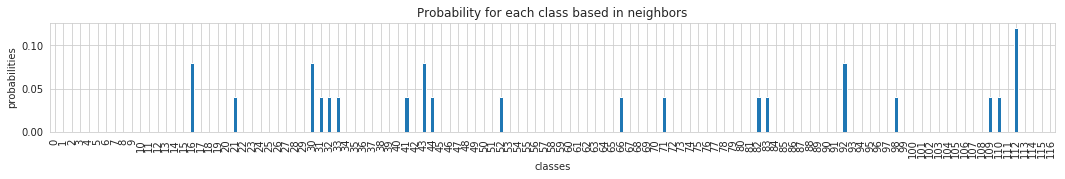

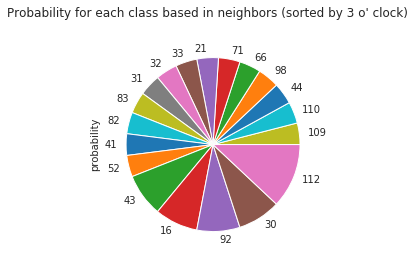

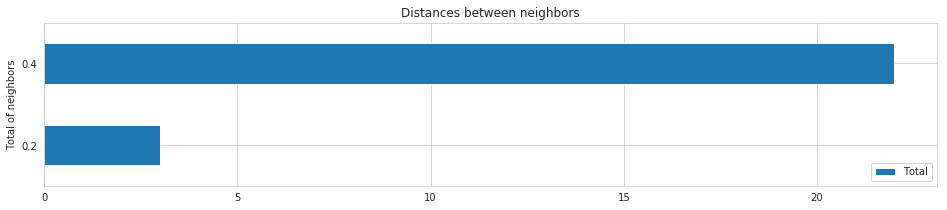

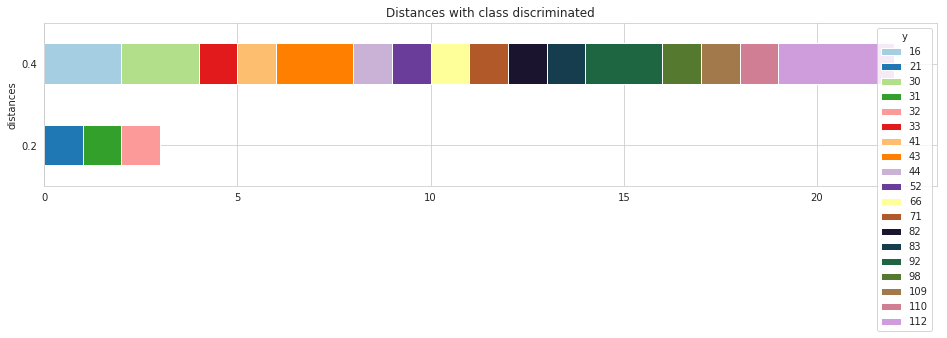

In [3]:
from experiments.model_evaluate.evaluate_method.evaluate_method import complete_missing_classes


def inspect_results(test_x, test_y):
    print('For this sample, the expected label is', test_y.values)
    print('and the attributes are ', test_x.values)

    # Model predict_proba remove some labels. Used class labels can obtain from model.classes_
    predict_proba = complete_missing_classes(
        model.predict_proba(test_x),
        classes=model.classes_,
        n_expected_classes=117
    )

    # Probability for each class
    plot = pd.DataFrame(predict_proba.T).plot.bar(legend=False, figsize=(18, 2), title="Probability for each class based in neighbors")
    plot.set_xlabel('classes')
    plot.set_ylabel('probabilities')

    pd.DataFrame(predict_proba.T, columns=['probability']).sort_values('probability').plot.pie(subplots=True, legend=False, title="Probability for each class based in neighbors (sorted by 3 o' clock)")
    

    # Neighbors distances
    distances, neighbors = model.kneighbors(test_x)
    distances_frame = pd.DataFrame(distances).T
    distances_frame['distances'] = distances_frame[0]
    distances_frame.columns = ['distances', 'Total']
    distances_frame.groupby('distances').count().plot.barh(title='Distances between neighbors', figsize=(16,3)).set_ylabel("Total of neighbors")

    # Distances with class discriminated
    y_recommended_by_neighbor = y.iloc[neighbors[0]].to_frame()
    y_recommended_by_neighbor.columns = ['y']
    y_recommended_by_neighbor['distances'] = distances[0]

    total_colors = len(y_recommended_by_neighbor['y'].unique())

    colors = sns.color_palette("Paired")
    colors += sns.color_palette("cubehelix", total_colors//2)

    y_recommended_by_neighbor.pivot_table(index='distances', columns='y', aggfunc='size', fill_value=0)\
     .plot.barh(stacked=True, figsize=(16, 3), color=colors, title='Distances with class discriminated')

test_example = test.iloc[0].to_frame().T
test_x, test_y = split_x_y(test_example, y_column=1)

inspect_results(test_x, test_y)

For this sample, the expected label is [72]
and the attributes are  [[27 74 86 30 71]]


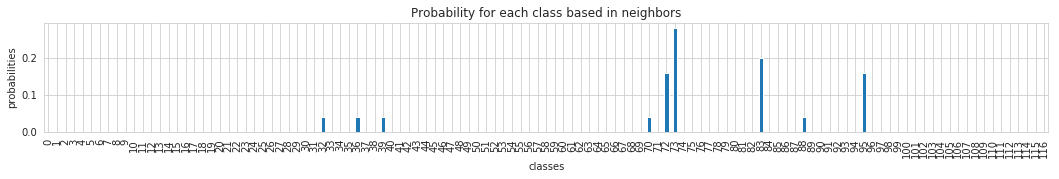

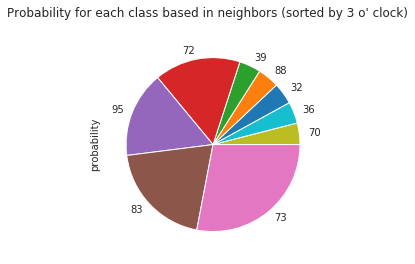

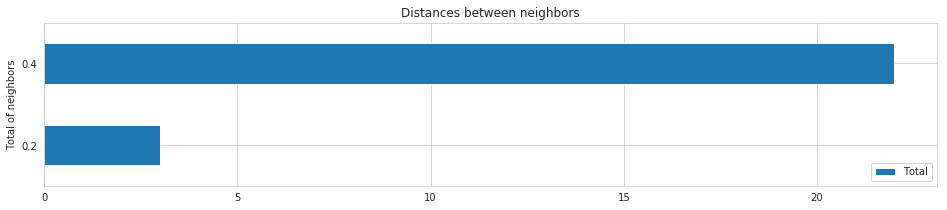

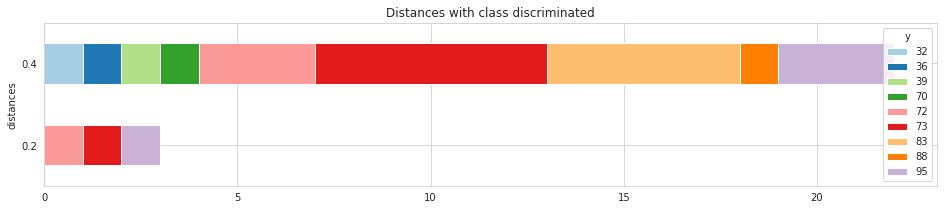

In [4]:
test_example = test.iloc[1].to_frame().T
test_x, test_y = split_x_y(test_example, y_column=1)

inspect_results(test_x, test_y)

For this sample, the expected label is [31]
and the attributes are  [[ 92   7  24  27 107]]


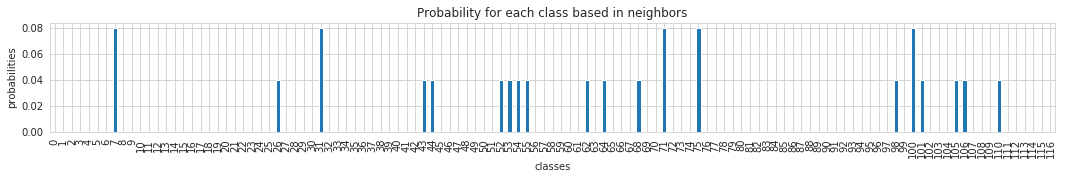

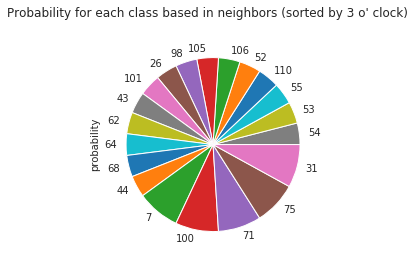

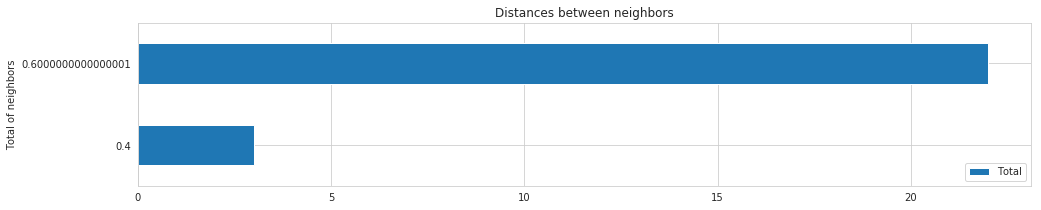

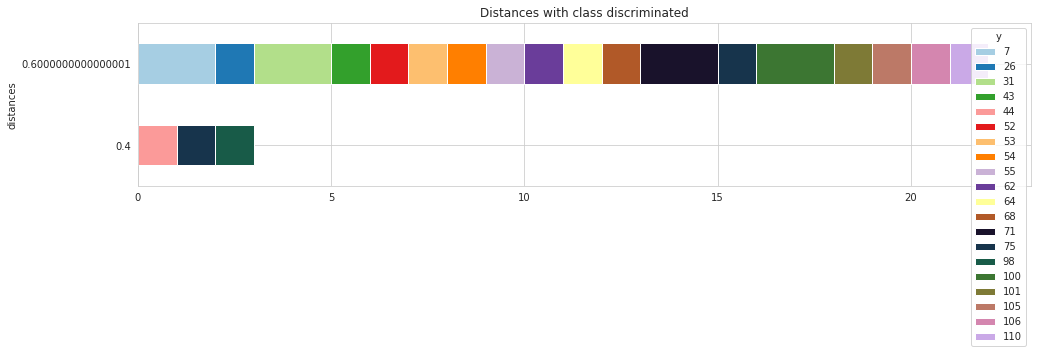

In [5]:
test_example = test.iloc[4].to_frame().T
test_x, test_y = split_x_y(test_example, y_column=1)

inspect_results(test_x, test_y)